# Applying Layers to Quantitative Maps
The primary way of getting data from a layers object is as a Pandas DataFrame. Your quantitative map and mask/anatomical image don't need to have the same field of view and voxel size, they are resampled to a common space as part of the `add_map` method. The `space` parameter of the QLayers class dictates whether any maps added to the object are resampled of the same space as the layers (`space=layers`) or if the layers are resampled to the native space of the map (`space=map`). The advantage of working in layer space is that you can produce a wide DataFrame where each row represents a region of tissue in the image and allows you to directly compare the depth and multiple quantitative parameters however it does involve a resampling operation to the quantitative parameter which may not be desirable (especially for noisy data). Working with `space=map` only allows you to produce a long DataFrame where each row is a single voxel of each quantitative map. Here we're going to work with `space=layers` and return both formats of DataFrame so you can see the difference. Most analysis is easier with a wide DataFrame so we'll save that variable for use in subsequent steps.
Start by importing the necessary libraries.

In [1]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import seaborn as sns

from qlayers import QLayers

sns.set()

Now we're going to import a mask and generate layers with a thickness of 1 mm excluding tissue within 10 mm of the pelvis.

In [2]:
mask_img = nib.load('data/kidney_mask.nii.gz')
qlayers = QLayers(mask_img, thickness=1, pelvis_dist=10, space='layers')
r2star_map = nib.load('data/r2star.nii.gz')
t1_map = nib.load('data/t1_registered.nii.gz')
qlayers.add_map(r2star_map, 'r2star')
qlayers.add_map(t1_map, 't1')

Making Mesh
Smoothing Mesh


Pelvis Distance Calculation: 100%|██████████| 3/3 [00:11<00:00,  3.81s/it]


In [3]:
qlayers.df_long

,depth,layer,measurement,value
0,0.691532,1.0,r2star,35.173016
1,0.640596,1.0,r2star,35.546364
2,0.885229,1.0,r2star,34.576439
3,0.680305,1.0,r2star,33.275753
4,0.622988,1.0,r2star,27.070265
...,...,...,...,...
25993,1.011228,2.0,t1,2372.752930
25994,1.099274,2.0,t1,1094.152222
25995,0.145987,1.0,t1,1351.835815
25996,1.185435,2.0,t1,922.929932


## DataFrames
Here is an example of how to retrieve a layers dataframe in long format. Note that every measurement is on a different row 
of the DataFrame.

In [4]:
print('An example of a long DataFrame')
qlayers.get_df('long').sample(n=100)

An example of a long DataFrame


,depth,layer,measurement,value
1452,7.921090,8.0,t1,1438.690796
23167,3.070961,4.0,r2star,16.509024
9873,9.106622,10.0,r2star,19.951300
15462,7.044881,8.0,t1,1522.299683
21780,9.554491,10.0,t1,1860.597168
...,...,...,...,...
5030,8.614227,9.0,r2star,-0.000061
16761,11.531033,12.0,t1,1811.737183
17264,3.927006,4.0,r2star,-0.000005
19380,10.379864,11.0,r2star,27.924768


And now an example of a wide DataFrame. Here each row represents properties of a single region of tissue i.e. the $T_1$ and 
$R_2^*$ of the same region. 

In [5]:
df = qlayers.get_df('wide')
# A little bit of data cleaning
df = df.loc[df['r2star'] > 0.1]
df = df.loc[df['t1'] > 0.1]
df = df.loc[df['layer'] > 0]
df = df.dropna()
print('An example of a wide DataFrame')
df.sample(n=100)

An example of a wide DataFrame


,depth,layer,r2star,t1
18182,2.479600,3.0,49.999969,830.443848
25187,7.304027,8.0,17.250000,1491.552002
981,7.609881,8.0,18.200880,1696.885132
225,3.661174,4.0,16.167454,1498.427856
9813,5.483145,6.0,17.793419,1505.549683
...,...,...,...,...
9085,3.738994,4.0,16.756792,2189.016602
14667,2.410548,3.0,18.561234,648.623413
4872,6.246225,7.0,20.113871,1326.467773
12614,5.033549,6.0,18.116539,1553.667480


## Layer Statistics
These large voxel-by-voxel DataFrames can be used to generate statistics for each layer.

In [6]:
df[['layer', 'r2star', 't1']].groupby('layer').agg(('mean', 'median', 'std', np.count_nonzero))

r2star                                               t1  \
            mean     median        std count_nonzero         mean   
layer                                                               
1.0    28.777927  27.386422  10.120994          1306  1427.316554   
2.0    24.798214  21.119667   9.922550          1152  1514.067368   
3.0    22.699811  18.791880   9.507372          1117  1548.529686   
4.0    21.311056  17.593157   8.999270          1079  1584.577592   
5.0    20.659930  17.642798   8.391686          1070  1555.793643   
6.0    20.322622  17.716091   8.013432           998  1535.698166   
7.0    20.008837  17.834057   6.875631           939  1556.361710   
8.0    20.357808  18.393726   6.256812           939  1590.342322   
9.0    21.486777  18.754271   7.210381          1249  1647.641340   
10.0   21.896243  19.833168   6.528540           973  1668.680325   
11.0   22.848923  20.875158   6.762447           800  1699.698935   
12.0   24.367501  22.374521   7.467851           780  1724.054959   
13.0   25.761510  23.751545   8.236693           681  1768.263152   
14.0   27.090914  25.005579   8.590587           627  1816.391434   
15.0   26.376643  24.508926   8.273556           937  1794.624822   
16.0   26.683109  25.606609   7.597819           489  1911.763796   
17.0   26.739680  25.025603   8.242154           370  1903.686099   
18.0   27.080702  26.185752   8.125888           246  1885.025251   
19.0   27.964653  26.761284   8.542669           167  1854.224052   
20.0   27.312497  26.466608   7.030809           164  1822.542544   
21.0   26.563904  26.340168   7.246280            65  2048.189515   
22.0   32.333422  30.151463  11.298019            25  1842.424917   
23.0   33.817001  29.618130   9.046841             5  1972.630908   

                                              
            median         std count_nonzero  
layer                                         
1.0    1432.761292  687.366178          1306  
2.0    1498.551514  521.878771          1152  
3.0    1502.680298  418.154056          1117  
4.0    1504.680908  387.597601          1079  
5.0    1515.112427  245.470044          1070  
6.0    1518.424866  183.277963           998  
7.0    1526.548950  222.644851           939  
8.0    1545.794434  261.664944           939  
9.0    1608.914917  251.010749          1249  
10.0   1629.775635  242.975416           973  
11.0   1657.771057  270.711344           800  
12.0   1686.763916  314.218625           780  
13.0   1727.257935  334.313298           681  
14.0   1759.498901  373.740812           627  
15.0   1747.250732  358.172194           937  
16.0   1814.361206  469.923051           489  
17.0   1863.104370  428.545985           370  
18.0   1872.476135  404.513906           246  
19.0   1826.735474  416.656298           167  
20.0   1736.938843  416.622615           164  
21.0   1752.625488  643.742097            65  
22.0   1678.638062  394.083905            25  
23.0   1783.244507  534.599383             5

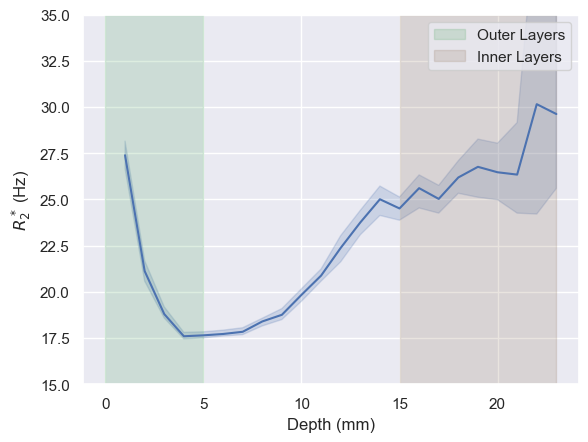

In [7]:
fig, ax = plt.subplots()
sns.lineplot(df, x='layer', y='r2star', ax=ax, estimator='median')
ax.set_xlabel('Depth (mm)')
ax.set_ylabel('$R_2^*$ (Hz)')
ax.set_ylim((15, 35))
ax.axvspan(0, 5, alpha=0.2, label='Outer Layers', color='C2')
ax.axvspan(15, 23, alpha=0.2, label='Inner Layers', color='C5')
ax.legend()